# Imports

In [1]:
import logging
import os
import pickle

import pandas
import hydra
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from einops import rearrange

from openretina.utils.misc import CustomPrettyPrinter
from openretina.data_io.hoefling_2024.constants import RGC_GROUP_NAMES_DICT
from openretina.eval.metrics import feve, correlation_numpy, MSE_numpy
from openretina.eval.oracles import oracle_corr_jackknife, global_mean_oracle


matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)  # to display logs in jupyter

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=30)

Let's import also the global config file for this model using hydra.

In [2]:
with hydra.initialize(config_path=os.path.join("..", "configs"), version_base="1.3"):
    cfg = hydra.compose(config_name="hoefling_2024_core_readout_low_res.yaml")

In [3]:
neuron_data_dict = hydra.utils.call(cfg.data_io.responses)
movies_dict = hydra.utils.call(cfg.data_io.stimuli)

2025-12-29 12:15:09,048 - INFO - Fetching file list for open-retina/open-retina...
2025-12-29 12:15:09,330 - INFO - Found target file at /home/tzenkel/openretina_cache/euler_lab/hoefling_2024/responses/rgc_natstim_2024-08-14.h5


Loading HDF5 file contents:   0%|          | 0/2077 [00:00<?, ?item/s]

Original dataset contains 7863 neurons over 67 fields
 ------------------------------------ 
Dropped 0 fields that did not contain the target cell types (67 remaining)
Overall, dropped 3034 neurons of non-target cell types (-38.59%).
 ------------------------------------ 
Dropped 0 fields with quality indices below threshold (67 remaining)
Overall, dropped 980 neurons over quality checks (-20.29%).
 ------------------------------------ 
Dropped 0 fields with classifier confidences below 0.25
Overall, dropped 705 neurons with classifier confidences below 0.25 (-18.32%).
 ------------------------------------ 
 ------------------------------------ 
Final dataset contains 3144 neurons over 67 fields
Total number of cells dropped: 4719 (-60.02%)


Upsampling natural spikes traces to get final responses.:   0%|          | 0/67 [00:00<?, ?it/s]

2025-12-29 12:15:23,809 - INFO - Fetching file list for open-retina/open-retina...
2025-12-29 12:15:23,980 - INFO - Found target file at /home/tzenkel/openretina_cache/euler_lab/hoefling_2024/stimuli/rgc_natstim_18x16_joint_normalized_2024-01-11.pkl


In [4]:
green_avg = np.average(movies_dict.test_movie[0], axis=[1, 2])
uv_avg = np.average(movies_dict.test_movie[1], axis=[1, 2])

In [5]:
neuron_data_dict.keys()

dict_keys(['session_1_ventral1_20200226', 'session_1_ventral1_20200528', 'session_1_ventral1_20200707', 'session_1_ventral1_20201021', 'session_1_ventral1_20201030', 'session_1_ventral1_20210929', 'session_1_ventral1_20210930', 'session_1_ventral2_20200302', 'session_1_ventral2_20200707', 'session_1_ventral2_20201021', 'session_1_ventral2_20201022', 'session_1_ventral2_20201030', 'session_1_ventral2_20201117', 'session_1_ventral2_20210910', 'session_1_ventral2_20210921', 'session_1_ventral2_20210929', 'session_1_ventral2_20210930', 'session_1_ventral2_20211130', 'session_2_ventral1_20200226', 'session_2_ventral1_20200303', 'session_2_ventral1_20200528', 'session_2_ventral1_20200529', 'session_2_ventral1_20200701', 'session_2_ventral1_20201021', 'session_2_ventral1_20201030', 'session_2_ventral1_20210929', 'session_2_ventral2_20200303', 'session_2_ventral2_20201016', 'session_2_ventral2_20201021', 'session_2_ventral2_20201022', 'session_2_ventral2_20201030', 'session_2_ventral2_20201117

In [6]:
df_low_res = pandas.read_csv("/home/tzenkel/GitRepos/open-retina/model_responses/hoefling_2024_GRU_low_res.csv")
df_high_res = pandas.read_csv("/home/tzenkel/GitRepos/open-retina/model_responses/hoefling_2024_GRU_high_res.csv")

# Add prefixes to low_res and high_res columns (except join keys)
df_low_res_prefixed = df_low_res.add_prefix("low_")
df_high_res_prefixed = df_high_res.add_prefix("high_")

# Restore join keys back to original for merging
df_low_res_prefixed = df_low_res_prefixed.rename(columns={"low_session":"session", "low_roi_ids":"roi_ids"})
df_high_res_prefixed = df_high_res_prefixed.rename(columns={"high_session":"session", "high_roi_ids":"roi_ids"})

# Merge on session and roi_ids
df = pandas.merge(
    df_low_res_prefixed,
    df_high_res_prefixed,
    on=["session", "roi_ids"],
    suffixes=("_low", "_high"),
)

print(df.keys())

Index(['low_Unnamed: 0', 'low_poisson_loss_to_average', 'low_model_response',
       'low_corr_to_average', 'low_mse_to_average', 'low_feve',
       'low_jackknife', 'low_corr_0', 'low_mse_0', 'low_corr_1', 'low_mse_1',
       'low_corr_2', 'low_mse_2', 'session', 'roi_ids', 'low_group_assignment',
       'low_scan_sequence_idx', 'high_Unnamed: 0',
       'high_poisson_loss_to_average', 'high_model_response',
       'high_corr_to_average', 'high_mse_to_average', 'high_feve',
       'high_jackknife', 'high_corr_0', 'high_mse_0', 'high_corr_1',
       'high_mse_1', 'high_corr_2', 'high_mse_2', 'high_group_assignment',
       'high_scan_sequence_idx'],
      dtype='object')


                          session  roi_ids  high_feve  low_feve  \
2335  session_3_ventral2_20201117       82   0.783007  0.505121   

      high_corr_to_average  low_corr_to_average  
2335              0.765401             0.758744  
33


2025-12-29 12:21:54,282 - INFO - maxp pruned
2025-12-29 12:21:54,307 - INFO - cmap pruned
2025-12-29 12:21:54,313 - INFO - kern dropped
2025-12-29 12:21:54,313 - INFO - post pruned
2025-12-29 12:21:54,315 - INFO - FFTM dropped
2025-12-29 12:21:54,317 - INFO - GPOS pruned
2025-12-29 12:21:54,321 - INFO - GSUB pruned
2025-12-29 12:21:54,331 - INFO - glyf pruned
2025-12-29 12:21:54,335 - INFO - Added gid0 to subset
2025-12-29 12:21:54,336 - INFO - Added first four glyphs to subset
2025-12-29 12:21:54,336 - INFO - Closing glyph list over 'MATH': 51 glyphs before
2025-12-29 12:21:54,337 - INFO - Glyph names: ['.notdef', '.null', 'A', 'G', 'H', 'I', 'L', 'M', 'P', 'R', 'S', 'T', 'U', 'a', 'bracketleft', 'bracketright', 'c', 'colon', 'comma', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'zero']
2025-12-29 12:21:54,337 - 

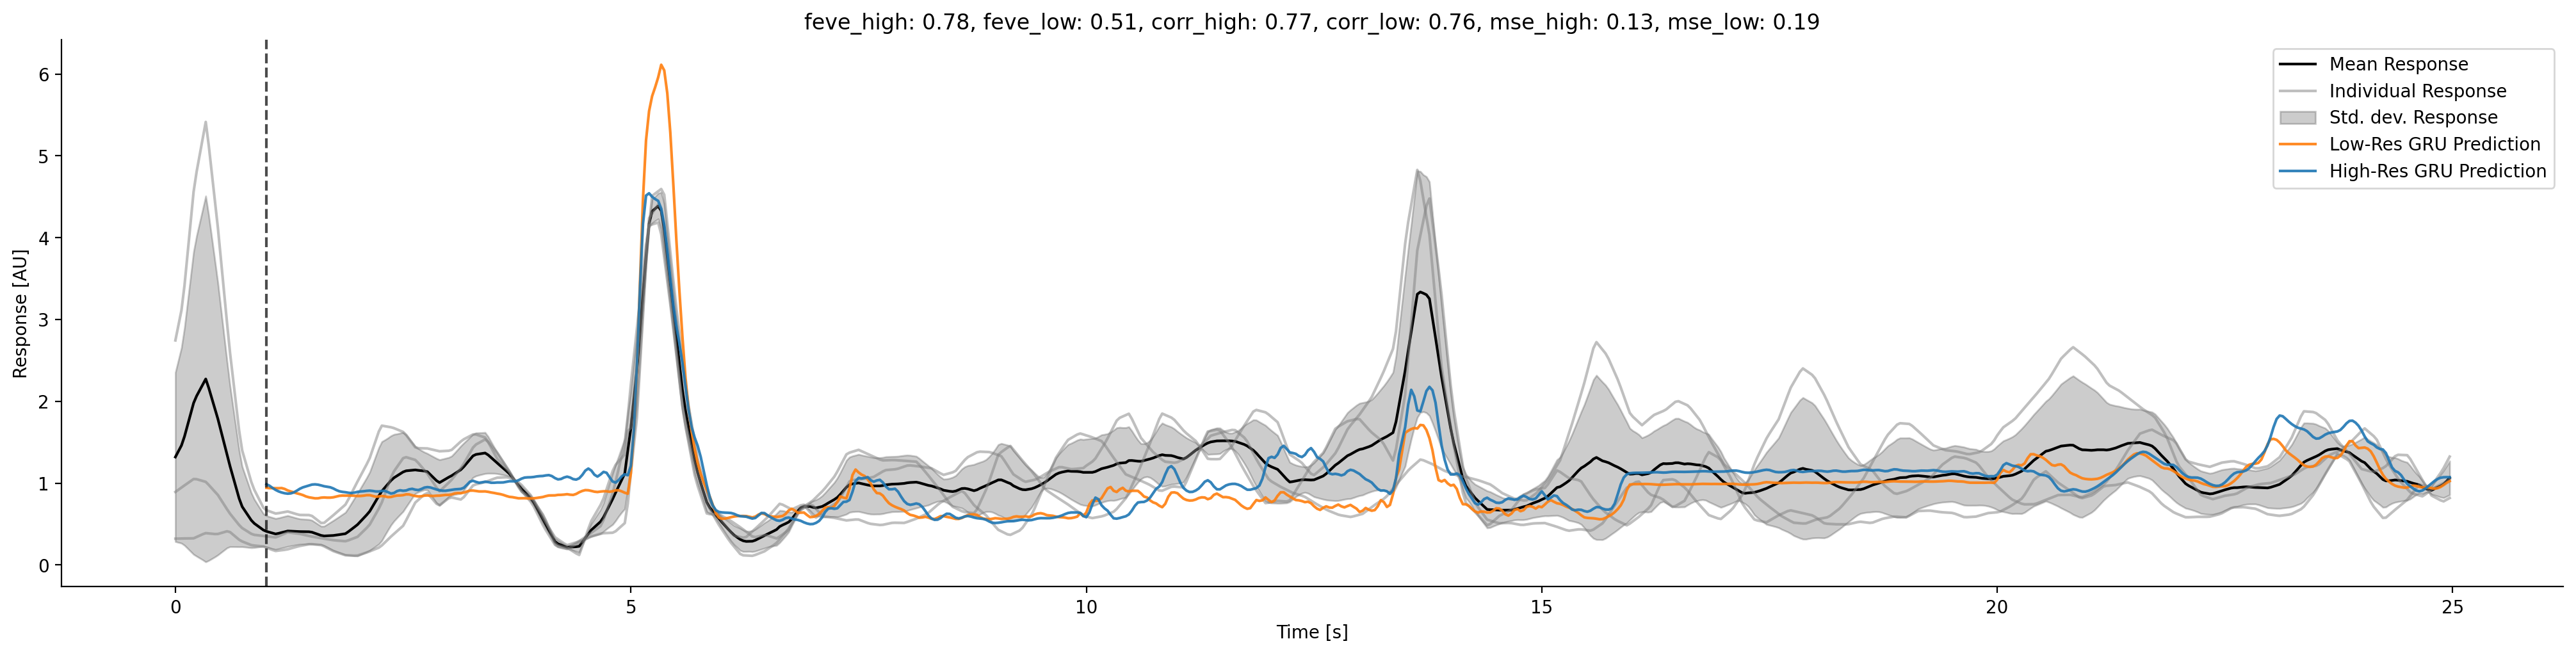

In [8]:
df["corr_diff"] = df["high_corr_to_average"] - df["low_corr_to_average"]
df["feve_diff"] = df["high_feve"] - df["low_feve"]
df["feve_minus_corr_diff"] = df["feve_diff"] - df["corr_diff"]

# Exclude cells where high_feve == 1.0 and low_feve == 0.0
filtered_df = df[(df["high_feve"] < 1.0) & (df["low_feve"] > 0.0) & (df["corr_diff"] <= 0.05) & (df["low_corr_to_average"] > 0.7) & (df["high_feve"] > 0.7) & (df["high_mse_to_average"] < 0.2)]
# Get the 5 cells (rows) with the highest feve_minus_corr_diff
k = 1
topk = filtered_df.nlargest(k, "feve_minus_corr_diff")

print(topk[["session", "roi_ids", "high_feve", "low_feve", "high_corr_to_average", "low_corr_to_average"]])

# One cell per subplot: Compare predicted traces ("low_model_response" vs. "high_model_response") for top 5 cells
fig, axes = plt.subplots(k, 1, figsize=(20, k*5), constrained_layout=True)
for i, (_, row) in enumerate(topk.iterrows()):
    if isinstance(axes, np.ndarray):
        ax = axes[i]
    else:
        ax = axes
    # The model responses may be stored as strings; try to eval or np.array them
    session_name = row["session"]
    roi_id = row["roi_ids"]
    neuron_idx = np.where(neuron_data_dict[session_name].session_kwargs["roi_ids"] == roi_id)[0][0]
    print(neuron_idx)
    neuron_responses = neuron_data_dict[session_name].test_by_trial[neuron_idx]
    avg_neuron_resp = np.average(neuron_responses, axis=1)
    std_neuron_resp = np.std(neuron_responses, axis=1)
    group_id = neuron_data_dict[session_name].session_kwargs["group_assignment"][neuron_idx]

    # Plot all trials
    resp_time = np.arange(avg_neuron_resp.shape[0]) / 30
    ax.plot(resp_time, avg_neuron_resp, color="black", label="Mean Response")
    for i, resp in enumerate(neuron_responses.T):
        if i == 0:
            label = "Individual Response"
        else:
            label=None
        ax.plot(resp_time, resp, color="grey", alpha=0.5, label=label)
    # Plot mean with variance (shaded std)
    ax.fill_between(
        resp_time,
        avg_neuron_resp - std_neuron_resp,
        avg_neuron_resp + std_neuron_resp,
        color="black",
        alpha=0.2,
        label="Std. dev. Response"
    )

    low_pred = np.array(eval(row["low_model_response"])) if isinstance(row["low_model_response"], str) else np.array(row["low_model_response"])
    high_pred = np.array(eval(row["high_model_response"])) if isinstance(row["high_model_response"], str) else np.array(row["high_model_response"])

    lag = avg_neuron_resp.shape[0] - low_pred.shape[0]
    pred_time = np.arange(lag, avg_neuron_resp.shape[0]) / 30
    ax.plot(pred_time, low_pred, label="Low-Res GRU Prediction", color="tab:orange", alpha=0.9)
    ax.plot(pred_time,  high_pred, label="High-Res GRU Prediction", color="tab:blue", alpha=0.9)
    # Add horizontal stripped (dashed) line at 1 second
    ax.axvline(1.0, color='k', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title(#f"Session: {row['session']}, ROI: {row['roi_ids']}\n"
                      f"feve_high: {row['high_feve']:.2f}, feve_low: {row['low_feve']:.2f}, "
                      f"corr_high: {row['high_corr_to_average']:.2f}, corr_low: {row['low_corr_to_average']:.2f}, "
                      f"mse_high: {row['high_mse_to_average']:.2f}, mse_low: {row['low_mse_to_average']:.2f}")
    ax.set_ylabel("Response [AU]")
    ax.legend()
    # ax.grid(True)
ax.set_xlabel("Time [s]")
# plt.suptitle("Comparison of predicted responses\n(High vs. Low Resolution Models, Top 5 cells by feve_minus_corr_diff)", y=1.02)
sns.despine()
fig.savefig('/home/tzenkel/Downloads/example_neuron_metrics.pdf', dpi=fig.dpi)
plt.show()

